In [ ]:
# https://www.kaggle.com/akshay235/bert-implementation-on-ner-corpus

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv('input/tagged_3k.csv', encoding='cp1252')
data.head(50)

,line_id,word,tag
0,1,anyone,O
1,1,good,O
2,1,with,O
3,1,exploiting,O
4,1,cisco,B-SW
5,1,asa,I-SW
6,1,with,O
7,1,extrabacon,B-ATK
8,1,?,O
9,2,Do,O


In [2]:
# there are no missing values right now, so it is tagged properly
data.isnull().sum(axis=0)

line_id    0
word       0
tag        0
dtype: int64

In [3]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("line_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [4]:
getter = SentenceGetter(data)

In [5]:
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[0]

'anyone good with exploiting cisco asa with extrabacon ?'

In [6]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[4])

['O', 'O', 'O', 'O', 'O', 'B-SCN', 'O']


In [7]:
tags_vals = list(set(data["tag"].values))
tag2idx = {t: i for i, t in enumerate(tags_vals)}

In [8]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam
from tqdm import tqdm, trange

In [9]:
MAX_LEN = 40
bs =64

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
device

device(type='cpu')

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [36]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print(tokenized_texts[4])

['i', 'am', 'a', 'giant', 'drunk', 'do', '##rk', '!']


In [37]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [38]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [39]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [40]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.3)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.3)

In [41]:
tr_inputs = torch.tensor(tr_inputs).to(device).long()
val_inputs = torch.tensor(val_inputs).to(device).long()
tr_tags = torch.tensor(tr_tags).to(device).long()
val_tags = torch.tensor(val_tags).to(device).long()
tr_masks = torch.tensor(tr_masks).to(device).long()
val_masks = torch.tensor(val_masks).to(device).long()

In [42]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [44]:
model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(tag2idx))

100%|████████████████████████████████████████████████████████████████| 404400730/404400730 [04:46<00:00, 1409761.85B/s]


In [45]:
model.cpu()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
      

In [46]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [47]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [48]:
epochs = 5
max_grad_norm = 1.0

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(tr_loss/nb_tr_steps)
    
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    
    validation_loss_values.append(eval_accuracy/nb_eval_steps)
    
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    #print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]

Train loss: 2.332900881767273


Epoch:  20%|███████████████▍                                                             | 1/5 [01:30<06:02, 90.69s/it]

Validation loss: 0.957707017660141
Validation Accuracy: 0.971484375
Train loss: 0.6938581267992655


Epoch:  40%|██████████████████████████████▊                                              | 2/5 [02:50<04:22, 87.48s/it]

Validation loss: 0.45389364659786224
Validation Accuracy: 0.971484375
Train loss: 0.4567442238330841


Epoch:  60%|██████████████████████████████████████████████▏                              | 3/5 [04:20<02:56, 88.22s/it]

Validation loss: 0.4453228712081909
Validation Accuracy: 0.971484375
Train loss: 0.44707473119099933


Epoch:  80%|█████████████████████████████████████████████████████████████▌               | 4/5 [05:39<01:25, 85.33s/it]

Validation loss: 0.43923190236091614
Validation Accuracy: 0.971484375
Train loss: 0.4485330681006114


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [07:05<00:00, 85.10s/it]

Validation loss: 0.44261765480041504
Validation Accuracy: 0.971484375


In [49]:
model.eval()
predictions = []
true_labels = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
        
    logits = logits.detach().cpu().numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

pred_tags = [[tags_vals[p_i] for p_i in p] for p in predictions]
valid_tags = [[tags_vals[l_ii] for l_ii in l_i] for l in true_labels for l_i in l ]
print("Validation loss: {}".format(eval_loss/nb_eval_steps))
print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Validation loss: 0.44261765480041504
Validation Accuracy: 0.971484375
Validation F1-Score: 0.0


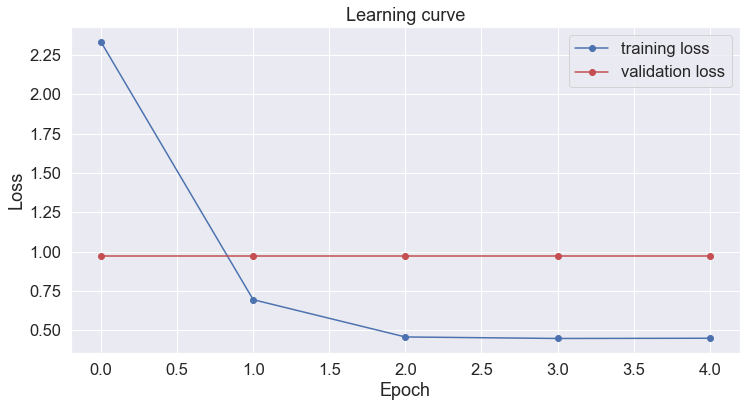

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# The plot below shows that the model is not learning my data it's underfitting my data 
# maybe becuase it's small
# and there is wide gap between training and validation, so model is suffering from high variance
# so the model needs to be more complex